# Tutorial: Image classification

##### Copyright 2019 The TensorFlow Authors.
Notebook modified by Julien Brajard julien.brajard@nersc.no for MAT330 course

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This short introduction of classication uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

This tutorial is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


Other useful imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np

If you are following along in your own development environment, rather than [Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb), see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the sample data from integers to floating-point numbers and split into training/test:

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f'Number of sample in the training set: {y_train.size}')
print(f'Number of sample in the testing set: {y_test.size}')

Number of sample in the training set: 60000
Number of sample in the testing set: 10000


Plot examples of the training set and test set

In [5]:
ntrain = 5 #Number of samples to plot from the training dataset
ntest = 5#Number of samples to plot from the testing dataset

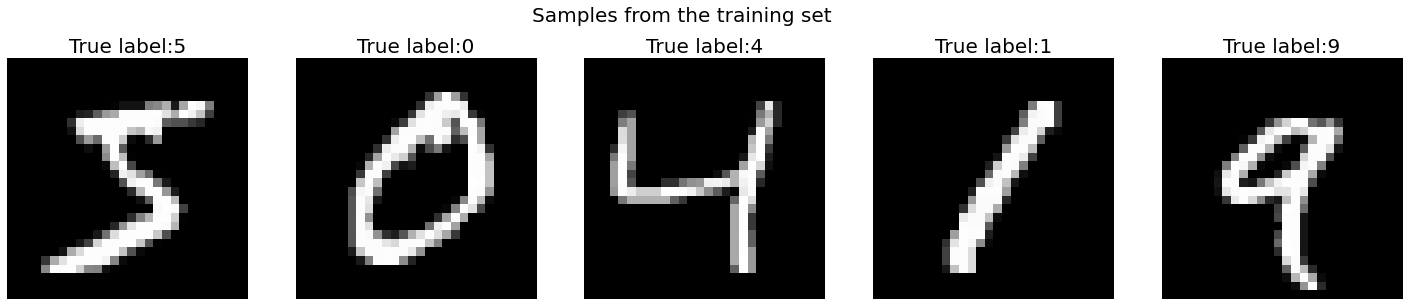

In [6]:
fig, ax = plt.subplots(ncols=ntrain, figsize=(ntrain*5,5))
for i,a in enumerate(ax):
    a.imshow(x_train[i], cmap='gray')
    a.axis('off')
    a.set_title(f'True label:{y_train[i]}',fontsize=20)
fig.suptitle('Samples from the training set',fontsize=20);

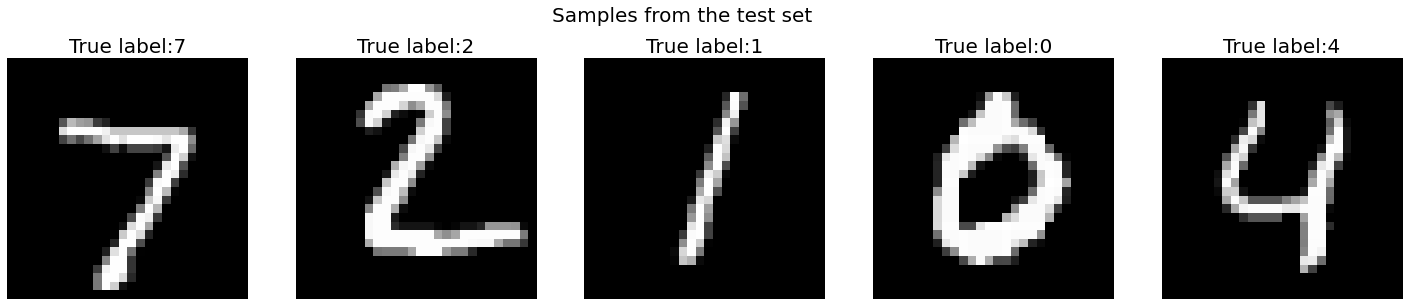

In [7]:
fig, ax = plt.subplots(ncols=ntest, figsize=(ntrain*5,5))
for i,a in enumerate(ax):
    a.imshow(x_test[i], cmap='gray')
    a.axis('off')
    a.set_title(f'True label:{y_test[i]}',fontsize=20)
fig.suptitle('Samples from the test set',fontsize=20);

## One hot encoding
encode the outputs as a 10-dimensional vector

In [8]:
y_train_onehot = tf.one_hot(y_train,10)
y_test_onehot = tf.one_hot(y_test,10)

In [9]:
# An example
print(f'Label of the first sample: {y_train[0]}')
print(f"Encoding of the first sample's label: {y_train_onehot[0]}")

Label of the first sample: 5
Encoding of the first sample's label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Build a machine learning model

Build a `tf.keras.Sequential` model by stacking layers. Here no convolutionnal layers are used.

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


#Not used for the moment
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
    tf.keras.layers.Conv2D(32,5, activation='relu'),
    tf.keras.layers.Conv2D(32,5, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Try to add some features:

#L2 regularization, ex: tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))

#Dropout, ex: tf.keras.layers.Dropout(0.2)

#Batchnorm, ex: tf.keras.layers.BatchNormalization()


For each example, the model returns a vector of *probabilities* for each class

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Prdiction for the first image of the training
predictions = model(x_train[:1]).numpy()
predictions

array([[0.12432682, 0.07075611, 0.10917601, 0.09224107, 0.1422925 ,
        0.0970946 , 0.09606487, 0.11807542, 0.0692419 , 0.08073071]],
      dtype=float32)

In [13]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [14]:
loss_fn(y_train_onehot[:1], predictions).numpy()

2.3320696

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [15]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [16]:
history = model.fit(x_train, y_train_onehot, epochs=5, batch_size=32, validation_data=(x_test, y_test_onehot))

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4355 - accuracy: 0.8768 - val_loss: 0.1484 - val_accuracy: 0.9559
Epoch 2/5
1875/1875 [==============================] - 2s 931us/step - loss: 0.1258 - accuracy: 0.9627 - val_loss: 0.0999 - val_accuracy: 0.9697
Epoch 3/5
1875/1875 [==============================] - 2s 911us/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 0.0805 - val_accuracy: 0.9751
Epoch 4/5
1875/1875 [==============================] - 2s 878us/step - loss: 0.0558 - accuracy: 0.9835 - val_loss: 0.0825 - val_accuracy: 0.9730
Epoch 5/5
1875/1875 [==============================] - 2s 877us/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 0.0744 - val_accuracy: 0.9775


We can plot the cost fuction optimisation as the function of the epoch

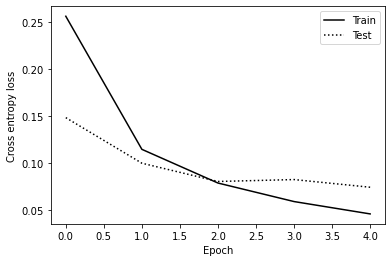

In [17]:
plt.plot(history.epoch,history.history['loss'], '-k', label='Train')
plt.plot(history.epoch,history.history['val_loss'], ':k', label='Test')
plt.legend()
plt.ylabel('Cross entropy loss')
plt.xlabel('Epoch');


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [18]:
model.evaluate(x_test,  y_test_onehot, verbose=2)

313/313 - 0s - loss: 0.0744 - accuracy: 0.9775


[0.07435532659292221, 0.9775000214576721]

The image classifier is now trained to ~98% accuracy on this dataset.

Now, let's predict the label of the test dataset

In [19]:
ytest_prediction = model.predict(x_test)
ytest_prediction[:1]

array([[1.0000688e-07, 9.0122496e-09, 7.6268652e-06, 1.4836663e-05,
        6.9173048e-12, 3.8902684e-08, 3.7769882e-13, 9.9997699e-01,
        3.0831604e-08, 4.2474093e-07]], dtype=float32)

Each prediction gives a vector of probability, the predicted label corresponds to the highest probability

In [20]:
ytest_prediction_label = np.argmax(ytest_prediction,axis=1)

Now, let's have a look at the predictions of the test dataset

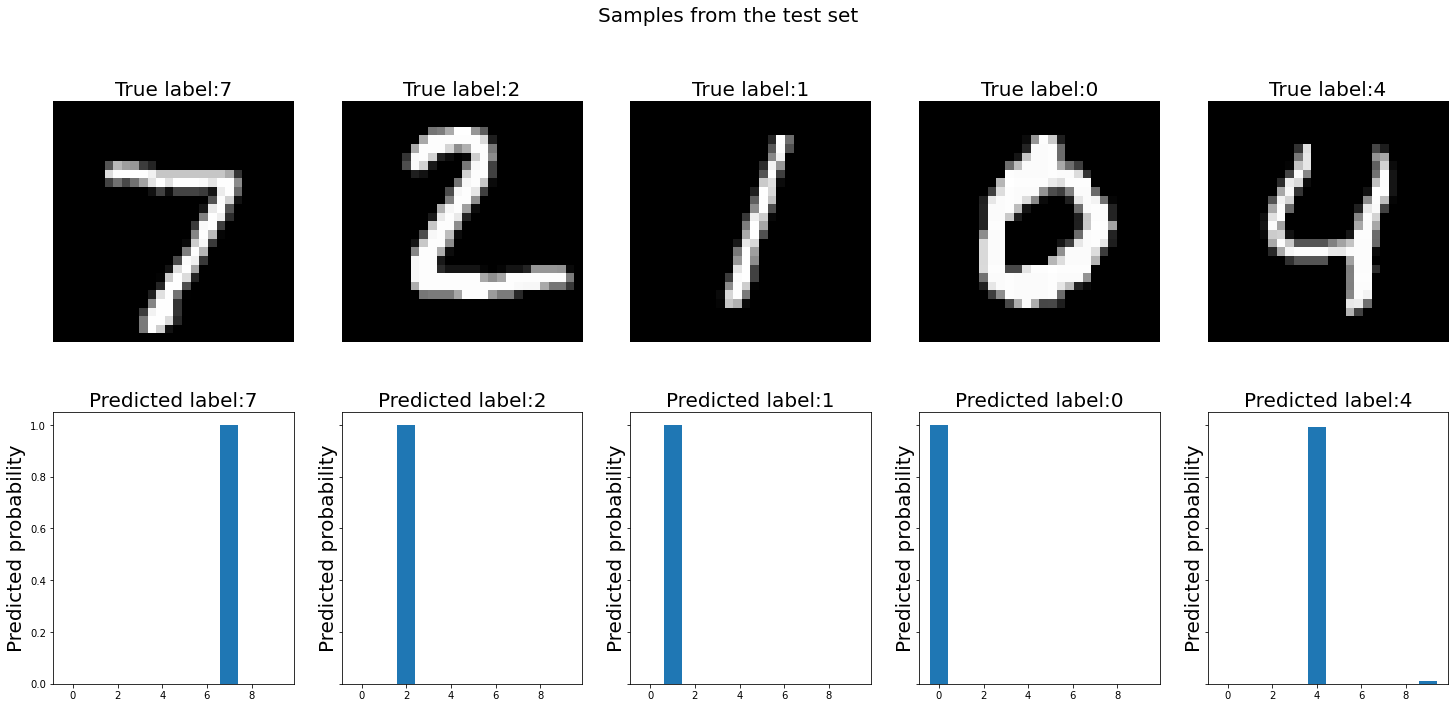

In [21]:
fig, ax = plt.subplots(ncols=ntest, nrows=2, figsize=(ntrain*5,11), sharey='row')
for i,a in enumerate(ax.T):
    a[0].imshow(x_test[i], cmap='gray')
    a[0].axis('off')
    a[0].set_title(f'True label:{y_test[i]}',fontsize=20)
    a[1].bar(np.arange(10),ytest_prediction[i])
    a[1].set_title(f'Predicted label:{ytest_prediction_label[i]}', fontsize=20)
    a[1].set_ylabel('Predicted probability',fontsize=20)
fig.suptitle('Samples from the test set',fontsize=20);

Now let's have a look at challenging predictions

In [22]:
#wrong = ytest_prediction_label != y_test
challenging = [115, 149, 151, 247, 259, 321, 340, 381, 445]

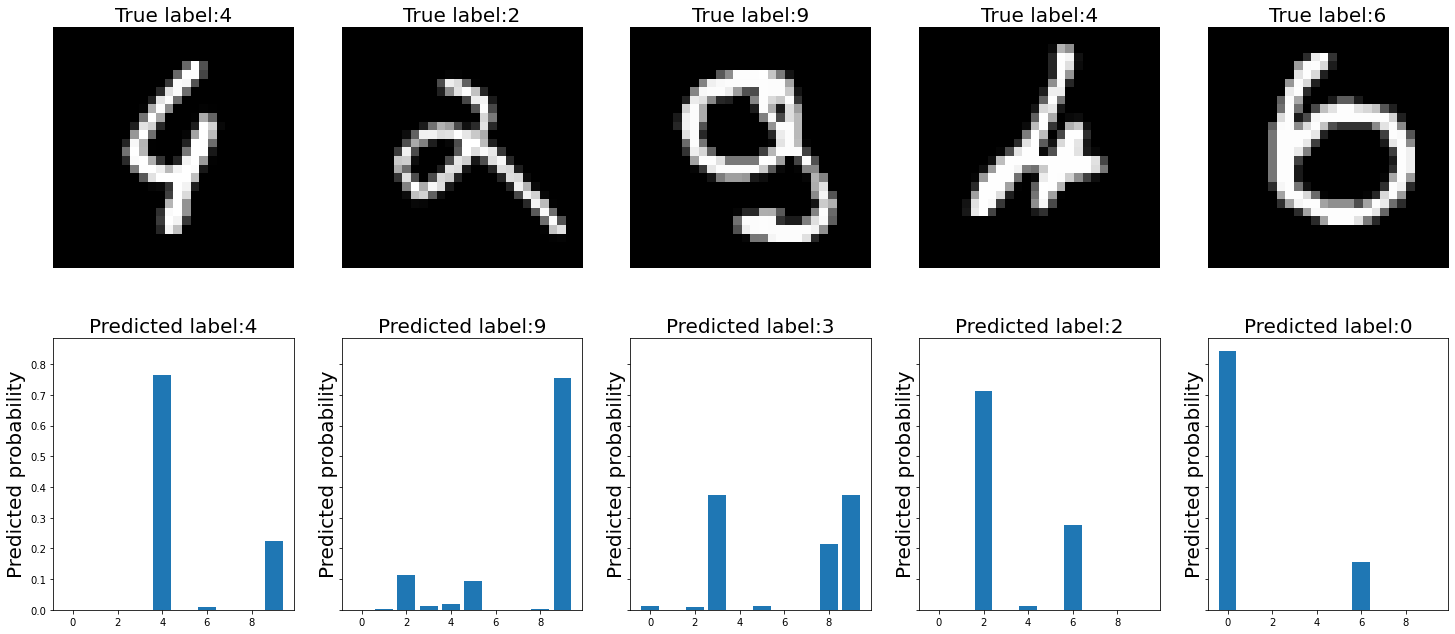

In [23]:
fig, ax = plt.subplots(ncols=ntest, nrows=2, figsize=(ntrain*5,11), sharey='row')

for i,a in enumerate(ax.T):
    a[0].imshow(x_test[challenging][i], cmap='gray')
    a[0].axis('off')
    a[0].set_title(f'True label:{y_test[challenging][i]}',fontsize=20)
    a[1].bar(np.arange(10),ytest_prediction[challenging][i])
    a[1].set_title(f'Predicted label:{ytest_prediction_label[challenging][i]}', fontsize=20)
    a[1].set_ylabel('Predicted probability',fontsize=20)